# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?


# Two Approaches

- Lexicons (word lists)

- Machine learning

In [15]:
#harish: check out afinn link

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [16]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('cock', -5), ('calms', 2), ('hooligan', -2), ('cut', -1), ('celebrate', 3), ('collide', -1), ('stamina', 2), ('yucky', -2), ('retard', -2), ('prepared', 1)]


In [17]:
len(afinn)

2462

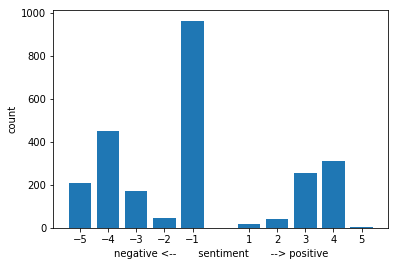

In [18]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [19]:
# How do we score a document?
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [20]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [21]:
##harish: return two values instead of returning score of zero

In [22]:
# Distinguish neutral from pos/neg.
# Return two scores per document.

def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [23]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [30]:
import configparser
from TwitterAPI import TwitterAPI

consumer_key = 'S7iQEmSfH2ICIaDfKhmmr4o4q'
consumer_secret = '7Anj5i1kSawK1sT0yglcnaUBoSXiVSo3y60YoD8DZXuXMpbwoV'
access_token = '759979935075151872-krTlTnjkV63ejn9dK93anDuu0JR7VGa'
access_token_secret = 'DbnQTinTQVY57w8Kh892HcmMl4ZdbGnnOp4F2REmVVtxY'

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets', {'q': 'mcdonalds', 'count': 100}):
    tweets.append(r)

In [31]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [33]:
#harish: tokenize words: NLP

In [35]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[10]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
RT @luluramadan: Cops are at Wellington McDonalds where tons of angry people lined up for hrs for Rick and Morty Szechuan sauce only to lea…
to
['rt', 'luluramadan', 'cops', 'are', 'at', 'wellington', 'mcdonalds', 'where', 'tons', 'of', 'angry', 'people', 'lined', 'up', 'for', 'hrs', 'for', 'rick', 'and', 'morty', 'szechuan', 'sauce', 'only', 'to', 'lea']


In [38]:
#HARISH: NOTE url is also tokenized! so avoid

In [39]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [40]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [47]:
#harish: check out false positives; one thing hard about sentiment
#classifier is that it might be true or accurate today;
#but tommorow it wont be! 

In [48]:
# Print top positives:
for tweet, pos, neg in sorted(positives, key=lambda x: x[1], reverse=True):
    print(pos, neg, tweet)

8 5 RT @_AlexHirsch: @danguterman @McDonalds @GOP “MORTY, nothing tops the sweet taste of Loestrin! It’s *burp* fucking amazing, it stops you f…
5 4 RT @sexualjumanji: you just pissed off the most powerful fan base in the world. u might think we are just nerds but we are troops and inven…
3 0 @esternoons @Good_Guy69 @McDonalds Lol stfu
3 0 @McDonalds I was so excited for the Szechuan sauce, I was at McDonalds 11 A.M. the cashier said we never heard of t… https://t.co/e7elzEtLIR
3 0 RT @TheHumaneLeague: Fast food giant @McDonalds is launching a trial of the "McVegan Burger!" Please RT! #progress https://t.co/gEhV8mJBOy
3 1 @Briijy @McDonaldsUK Sorry to hear that Briijy. Hope staff helped at the time, if not please log full details at https://t.co/BulG72WJvt
2 0 RT @CBSThisMorning: .@BonAppetit says @McDonalds is testing out a vegan-friendly sandwich called the #McVegan. https://t.co/ufeKYwR2wb http…
2 0 @KevinMSquires @McDonalds Thank you I was wondering about this
2 0 @painkilIrs we go

In [49]:
afinn_sentiment2(tokenize('Interested in a #job in #Redmond, WA? This could be a great fit: https://t.co/iF8xH1PuC4 #Hospitality #Hiring #CareerArc'),
                 afinn, verbose=True)

	interested=2
	great=3
	fit=1


(6, 0)

In [50]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 6 After yesterday's #schezuansauce bullshit, I will be boycotting @McDonalds until the bring back the sauce for real. Not this one day BS
3 5 Don't let the hipsters fool you. They love their corporate greed head food products. https://t.co/SXpEz7B2Qk
1 5 @guardian Ketchup 2! But I no longer want Mcdonalds. That shit sits in your gut! https://t.co/y1to62MZnO
0 4 RT @AliceSpecht: @McDonalds did you really get 17 packets a store or did your managers just make buku side cash #pissed #szechuansauce #eba…
0 4 No sausage or steak at McDonalds this morning. Can I die?
0 3 RT @luluramadan: Cops are at Wellington McDonalds where tons of angry people lined up for hrs for Rick and Morty Szechuan sauce only to lea…
0 3 RT @luluramadan: Cops are at Wellington McDonalds where tons of angry people lined up for hrs for Rick and Morty Szechuan sauce only to lea…
0 1 @mcdonalds No locations in my state, nearest #Szechuansauce an 8 hour drive away! Did you forgot about us down in Montana? #406
0 1 @Ariz

In [51]:
afinn_sentiment2(tokenize('@MikeyPoole Sorry about your order! To help us improve, can you provide the location here'),
                 afinn, verbose=True)

	sorry=-1
	help=2
	improve=2


(4, 1)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [52]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(), key=lambda x:x[1], reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

want count=15 sentiment=1
no count=4 sentiment=-1
pissed count=2 sentiment=-4
sorry count=2 sentiment=-1
like count=2 sentiment=2
please count=2 sentiment=1
angry count=2 sentiment=-3
boycotting count=1 sentiment=-2
tops count=1 sentiment=2
love count=1 sentiment=3
fucking count=1 sentiment=-4


In [54]:
[t for t in tokens if 'pissed' in t]

[['rt',
  'alicespecht',
  'mcdonalds',
  'did',
  'you',
  'really',
  'get',
  '17',
  'packets',
  'a',
  'store',
  'or',
  'did',
  'your',
  'managers',
  'just',
  'make',
  'buku',
  'side',
  'cash',
  'pissed',
  'szechuansauce',
  'eba'],
 ['rt',
  'sexualjumanji',
  'you',
  'just',
  'pissed',
  'off',
  'the',
  'most',
  'powerful',
  'fan',
  'base',
  'in',
  'the',
  'world',
  'u',
  'might',
  'think',
  'we',
  'are',
  'just',
  'nerds',
  'but',
  'we',
  'are',
  'troops',
  'and',
  'inven']]

In [57]:
#harish: check for false positives as far as context is concerned!
[t for t in tokens if 'want' in t]

[['rt',
  'guardian',
  'we',
  'want',
  'sauce',
  'police',
  'called',
  'over',
  'mcdonald',
  's',
  'rick',
  'and',
  'morty',
  'promotion',
  'https',
  't',
  'co',
  'at0xookcix'],
 ['rt',
  'guardian',
  'we',
  'want',
  'sauce',
  'police',
  'called',
  'over',
  'mcdonald',
  's',
  'rick',
  'and',
  'morty',
  'promotion',
  'https',
  't',
  'co',
  'at0xookcix'],
 ['rt',
  'guardian',
  'we',
  'want',
  'sauce',
  'police',
  'called',
  'over',
  'mcdonald',
  's',
  'rick',
  'and',
  'morty',
  'promotion',
  'https',
  't',
  'co',
  'at0xookcix'],
 ['mcdonald',
  's',
  'totally',
  'underestimated',
  'how',
  'many',
  'rick',
  'and',
  'morty',
  'fans',
  'want',
  'that',
  'mulan',
  'mcnugget',
  'sauce',
  'https',
  't',
  'co',
  'igd9kmpytm'],
 ['sundayreads',
  'apocalypse',
  'we',
  'want',
  'sauce',
  'police',
  'called',
  'after',
  'mcdonald',
  's',
  'rick',
  'and',
  'morty',
  'promotion',
  'heats',
  'up',
  'https',
  't',
  'co'

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

In [58]:
#harish: wordnet is a manually constructed data source 

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [64]:
#harish: imp for ADM project

In [65]:
# from nltk.corpus import sentiwordnet as swn
import nltk
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/harish/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
happy(n): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [67]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [68]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [69]:
hate = list(swn.senti_synsets('good', 'a'))[1]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

good(a): negative_score=0.00 positive_score=0.00 objective_score=1.00
